In [12]:
import os
import re
from cv2 import exp
import numpy as np
import matplotlib.pyplot as plt
from ArUCo_Markers_Pose import pose_data, pose_estimation
from Utilities.Helpers import toTime
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from ArUCo_Markers_Pose import *
from experiments import get_all_input
from datetime import datetime, timedelta
import seaborn as sns
import pandas as pd
import plotly.express as px
import heapq
from DataCleaner import clean
import webbrowser
import math
from collections import defaultdict

print(os.getcwd())
debug = True
fps = 30

c:\Users\me\Documents\GitHub\EDMO\EDMO_AI


In [13]:
def compute_speed(exp_edmo_poses:dict[int, dict[int, list]], filepath):
    '''
        Speed: units=meter per frame, sum of speed over the course of one experiment
        abs_speed: units=meter per frame, averaged sum of absolute speed over the course of one experiment
        Movement: units=meters, maximum displacement over the course of one experiment
    '''
    exp_edmo_movement = {}
    x_all_diff, y_all_diff, z_all_diff = [], [], []
    for exp_nb, positions in exp_edmo_poses.items():
        x_speed, y_speed, z_speed = 0.0, 0.0, 0.0
        abs_x_speed, abs_y_speed, abs_z_speed = 0.0, 0.0, 0.0
        nb_frames = len(positions)
        previous_el = None
        for i, pos_frame in enumerate(positions.items()):
            if previous_el is None:
                previous_el = pos_frame
                continue
            frame_diff = pos_frame[0] - previous_el[0]

            x, y, z = previous_el[1]
            x_next, y_next, z_next = pos_frame[1]
            x_diff = (x_next-x)/frame_diff
            y_diff = (y_next-y)/frame_diff
            z_diff = (z_next-z)/frame_diff
            
            threshold = 0.05
            if abs(x_diff) > threshold or abs(y_diff) > threshold:
                previous_el = pos_frame
                continue
            x_all_diff.append(x_diff)
            y_all_diff.append(y_diff)
            z_all_diff.append(z_diff)
            
            x_speed += x_diff
            y_speed += y_diff
            z_speed += z_diff
            
            abs_x_speed += abs(x_diff)
            abs_y_speed += abs(y_diff)
            abs_z_speed += abs(z_diff)
            
            previous_el = pos_frame
            
        global_speed = float(np.sqrt(x_speed**2 + y_speed**2 + z_speed**2))    
        xy_speed = float(np.sqrt(x_speed**2 + y_speed**2))
        abs_global_speed = float(np.sqrt(abs_x_speed**2 + abs_y_speed**2 + abs_z_speed**2))            
        abs_xy_speed = float(np.sqrt(abs_x_speed**2 + abs_y_speed**2))            
        exp_edmo_movement[exp_nb] =[x_speed, y_speed, z_speed, global_speed, xy_speed,\
                                    abs_x_speed/nb_frames, abs_y_speed/nb_frames, abs_z_speed/nb_frames, abs_global_speed/nb_frames, abs_xy_speed/nb_frames]
        f = open(f"{filepath}/speed_data.log", "w")
        json.dump(exp_edmo_movement, f)
    n = 3
    print(f'avg x displacement: {sum(x_all_diff) / len(x_all_diff)}, max : {heapq.nlargest(n, x_all_diff)}, min : {heapq.nsmallest(n, x_all_diff)}')
    print(f'avg y displacement: {sum(y_all_diff) / len(y_all_diff)}, max : {heapq.nlargest(n, y_all_diff)}, min : {heapq.nsmallest(n,y_all_diff)}')
    print(f'avg z displacement: {sum(z_all_diff) / len(z_all_diff)}, max : {heapq.nlargest(n, z_all_diff)}, min : {heapq.nsmallest(n,z_all_diff)}')
    return exp_edmo_movement

In [14]:
def merge_parameter_data(all_input, exp_edmo_movement): 
    '''
    Where speed_type is an integer:
    1,2,3 : x,y,z speed
    4,5 : xyz speed, xy speed
    6,7,8 : x,y,z average absolute speed
    9, 10 : xyz, xy average absolute speed
    '''
    global plot_data
    amp1, amp2, off1, off2, phb_diff, speeds = [], [], [], [], [], {}
    for i in range(10): 
        speeds[i] = []
    for frame, speed in exp_edmo_movement.items():
        inputs = all_input[frame] # (freq, (amp0, amp1), (off0, off1), (phb0, phb1))
        amp1.append(inputs[1][0])
        amp2.append(inputs[1][1])
        off1.append(inputs[2][0])
        off2.append(inputs[2][1])
        phb_diff.append(abs(inputs[3][0]-inputs[3][1]))
        for i in range(10): 
            speeds[i].append(speed[i]) 
        
    data = pd.DataFrame({
        'Amp_motor_1': amp1,
        'Amp_motor_2': amp2,
        'Offset_motor_1': off1,
        'Offset_motor_2': off2,
        'Phase_difference': phb_diff,
        'x speed' : speeds[0],
        'y speed' : speeds[1],
        'z speed' : speeds[2],
        'xyz speed' : speeds[3],
        'xy speed' : speeds[4],
        'x abs speed' : speeds[5],
        'y abs speed' : speeds[6],
        'z abs speed' : speeds[7],
        'xyz abs speed' : speeds[8],
        'xy abs speed' : speeds[9],
    })
    
    plot_data = pd.concat([plot_data, data], ignore_index=True) if plot_data is not None else data  
    

In [15]:
def toDatetime(time):
    t = datetime.strptime(time,"%H:%M:%S.%f")
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)

def find_exp_time_frames(input, motors_data):
    # Get the range of motor data that corresponds to the input 
    start_ends = []
    for i, motor in enumerate(motors_data):
        start_ends.append([])
        start_end = start_ends[i]
        j = 1
        while j < len(motor):
            motor_data = motor[j]
            data = motor_data.split(',')
            freq = abs(input[0] - float(data[1]))
            amp = abs(input[1][i] - float(data[2]))
            off = abs(input[2][i] - float(data[3]))        
            phb = abs(input[3][i] - float(data[4]))
            
            # start = when the motor data is close enough to the input
            if not len(start_end)%2:
                if freq < 0.1 and amp < 2 and off < 3 and phb < 0.07:
                    start_end.append(j)
                    
             # end = when the motor data is not close enough to the input anymore
            if len(start_end)%2:
                if freq > 0.1 or amp > 2 or off > 3 or phb > 0.07:
                    start_j = [start_end[i] for i in range(0, len(start_end)-1, 2)]
                    
                    if j - start_end[-1] <= 10: # ignore motor transitions (end and start too close)
                        del start_end[-1]
                        continue
                    elif len(start_j) > 0 and all(j < sj for sj in start_j): # ignore repeated motor data
                        del start_end[-1]
                        continue
                    else:
                        start_end.append(j)
            j += 1
    
    if len(start_ends) != len(motors_data):
        print(f'start ends: {start_ends}, input: {input}')
        return None

    start, end = 0, 0
    for i, se1 in enumerate(start_ends):
        for j, se2 in enumerate(start_ends):
            if i >= j:
                continue
            for index1 in range(0, len(se1)-1, 2):
                start1 = se1[index1]
                end1 = se1[index1+1]
                for index2 in range(0, len(se2)-1, 2):
                    start2 = se2[index2]
                    end2 = se2[index2+1]
                    
                    if (start1 > start2 and start1 > end2) or (start2 > start1 and start2 > end1):
                        continue
                    else:
                        if start != 0 and end != 0:
                            print(f'Found a second interval, verify the data !!! First: {start, end} second: {se1, se2}, indexes: {index1, index2}')
                        start = max(start1, start2)
                        end = min(end1, end2)
            
                        if start >= int(end):
                            start, end = 0, 0
    if start == 0 and end == 0:
        if debug:
            print(f'Skipped input: {input}, start ends: {start_ends}')
        return None
    return (start, int(end))


In [16]:
def data_analysis(dir, nbPlayers: int = 2):
    '''
    - Extract the aruco positions from the video
    - Compute the edmo's movement from the aruco positions and store in pose_d
    - For each experiment get the time stamp where the input values are reached
    - Compute the frame number corresponding to the timestamp and retrieve the frames from pose_d
    parse the frame's x, y, z and filter out the moment when the edmo was moved
    '''
    
    all_input = get_all_input(nbPlayers) # (freq, (amp0, amp1), (off0, off1), (phb0, phb1))
    
    param_speed_dict: dict[int, list[list, list]] = {}
    for folder in os.listdir(dir):
        if os.path.splitext(folder)[1] != '':
            continue
        print(f'folder: {folder}')
        filepath = f'{dir}/{folder}'
  
        # Get the edmo's position and rotation for each frame
        print('Getting the edmo\'s positions...')
        pose_d = pose_data.Pose_data(filepath)
        succeed = pose_d.get_pose()
        if not succeed:
            print('error: marker pose missing')
            continue
        edmo_poses = pose_d.edmo_poses
        edmo_rots = pose_d.edmo_rots
        
        # Matching the motor data with the input data and matching it with the corresponding frames
        print('Matching the edmo\'s movement with the input data...')
        motor0 = open(f"{filepath}/Motor0.log", 'r').readlines()
        motor1 = open(f"{filepath}/Motor1.log", 'r').readlines()

        exp_nbs = folder.split('-', 2)
        exp_start, exp_end = int(exp_nbs[0]), int(exp_nbs[1])
        input_range = all_input[exp_start:exp_end+1]
        
        motor_ranges = []
        exp_edmo_poses = {}
        skips = 0
        for i, exp_param in enumerate(input_range): 
            experiment_nb = exp_start+i
            motor_range = find_exp_time_frames(input_range[i], (motor0, motor1))
            if not motor_range:
                skips += 1
                continue
            motor_ranges.append(motor_range)
            
            time_start = toDatetime(motor1[motor_range[0]].split(',')[0])
            time_end = toDatetime(motor1[motor_range[1]].split(',')[0])
            frame_start = time_start.seconds * fps + round(time_start.microseconds/1e6 * fps)
            frame_end = time_end.seconds * fps + round(time_end.microseconds/1e6 * fps)
            # print(f'{frame_start} - {frame_end}')
            
        # Sanity check
            # input = input_range[i]
            # for i in range(motor_range[0], motor_range[1]):
            #     motor0_value = motor0[i]
            #     motor1_value = motor1[i]
            #     data0 = motor0_value.split(sep=',')
            #     data1 = motor1_value.split(sep=',')

            #     freq = abs(input[0] - float(data0[1]))
            #     amp = abs(input[1][0] - float(data0[2]))
            #     off = abs(input[2][0] - float(data0[3]))        
            #     phb = abs(input[3][0] - float(data0[4]))
                
            #     if freq > 0.1 or amp > 2 or off > 3 or phb > 0.07:
            #         print("Mistake in motor0 range => not corresponding to the input")
                    
            #     freq = abs(input[0] - float(data1[1]))
            #     amp = abs(input[1][1] - float(data1[2]))
            #     off = abs(input[2][1] - float(data1[3]))        
            #     phb = abs(input[3][1] - float(data1[4]))
                
            #     if freq > 0.1 or amp > 2 or off > 3 or phb > 0.07:
            #         print("Mistake in motor1 range => not corresponding to the input")
            

            for frame in range(frame_start, frame_end):
                if frame in edmo_poses:
                    if experiment_nb not in exp_edmo_poses:
                        exp_edmo_poses[experiment_nb] = {}
                    exp_edmo_poses[experiment_nb][frame] = edmo_poses[frame]
        print(f'inputs skipped : {skips}')
        with open(f'{filepath}/edmo_pose.log', 'w') as f:
            json.dump(exp_edmo_poses, f)
        print('Computing the edmo\'s speed ...')
        exp_edmo_movement = compute_speed(exp_edmo_poses, filepath)
        merge_parameter_data(all_input, exp_edmo_movement)        
    return plot_data

In [6]:
plot_data = None
# path = './exploreData/Snake/'
# for folder in os.listdir(path):
#     print(f'folder: {folder}')
#     filepath = f'{path}/{folder}'
#     files = os.listdir(filepath)
#     # Extract the poses from the video
#     if 'marker_pose.log' not in files:
#         video = None
#         for file in files:
#             if os.path.splitext(file)[1].lower() == '.mp4':
#                 video = f'/{file}'
#         print("analyzing the video...")
#         aruco_pose = pose_estimation.Aruco_pose(filepath+video)
#         aruco_pose.pose_estimation()

# print('Cleaning ...')
# clean(path, True)

print('Processing the data...')
path = './cleanData/Snake/'
plot_data = data_analysis(path)

with open(f'cleanData/Snake/plot data.log', 'w') as f:
    json.dump(plot_data.to_dict(orient='records'), f)

Processing the data...
folder: 0-179
Getting the edmo's positions...
nb of frames: 54097
Matching the edmo's movement with the input data...
Skipped input: (1, (20, 20), (0, 0), [0.0, 5.585053606381854]), start ends: [[61, 4426], []]
inputs skipped : 1
Computing the edmo's speed ...
avg x displacement: -2.4723396411004577e-05, max : [0.04944045321467949, 0.04906901539329278, 0.04792976739564253], min : [-0.04898209815323351, -0.04608556429844923, -0.04353107755866337]
avg y displacement: 2.685424449595349e-05, max : [0.024473105492959668, 0.023589671043192317, 0.023032685226235916], min : [-0.024703853815346788, -0.024082869345387392, -0.023675241784223977]
avg z displacement: 3.846602962278886e-06, max : [0.08997613621019995, 0.08450232563296245, 0.08418574641019849], min : [-0.08189224632749781, -0.07372520341652111, -0.07319742526031092]
folder: 1080-1259
Getting the edmo's positions...
nb of frames: 54095
Matching the edmo's movement with the input data...
Skipped input: (1, (40, 4

In [118]:
    
# Retrieve the data from the json file
with open('cleanData/Snake/plot data.log', 'r') as f:
    data = json.load(f)

# # Convert to DataFrame
plot_data = pd.DataFrame.from_records(data)
print(plot_data)

      Amp_motor_1  Amp_motor_2  Offset_motor_1  Offset_motor_2  \
0              20           20               0               0   
1              20           20               0               0   
2              20           20               0               0   
3              20           20               0               0   
4              20           20               0               0   
...           ...          ...             ...             ...   
2928           40           40              60             150   
2929           40           40              60             150   
2930           40           40              60             150   
2931           40           40              60             150   
2932           40           40              60             150   

      Phase_difference   x speed   y speed   z speed  xyz speed  xy speed  \
0             0.000000 -0.090271 -0.011717  0.031528   0.096334  0.091029   
1             0.698132 -0.091729  0.006284  0.085057 

# <ins> Parallel Plot </ins>

In [119]:
def parallel_coord(plot_data, color_scale, speed_type):
    fig = go.Figure(data=go.Parcoords(
        line=dict(
            color=plot_data[speed_type],  # Color by 'Speed'
            colorscale=color_scale,  
            showscale=True,  # Show the color scale
            cmin=plot_data[speed_type].min(),  # Set the color scale minimum to the minimum value of 'Speed'
            cmax=plot_data[speed_type].max()   # Set the color scale maximum to the maximum value of 'Speed'
        ),
        dimensions=[
            dict(
                label='Amp_motor_1', 
                values=plot_data['Amp_motor_1'],
                range=[plot_data['Amp_motor_1'].min(), plot_data['Amp_motor_1'].max()]
            ),
            dict(
                label='Amp_motor_2', 
                values=plot_data['Amp_motor_2'],
                range=[plot_data['Amp_motor_2'].min(), plot_data['Amp_motor_2'].max()]
            ),
            dict(
                label='Offset_motor_1', 
                values=plot_data['Offset_motor_1'],
                range=[plot_data['Offset_motor_1'].min(), plot_data['Offset_motor_1'].max()]  # Set the range based on data
            ),
            dict(
                label='Offset_motor_2', 
                values=plot_data['Offset_motor_2'],
                range=[plot_data['Offset_motor_2'].min(), plot_data['Offset_motor_2'].max()]
            ),
            dict(
                label='Phase_difference', 
                values=plot_data['Phase_difference']*180/math.pi,
                range=[plot_data['Phase_difference'].min()*180/math.pi, plot_data['Phase_difference'].max()*180/math.pi]
            ),
            dict(
                label=speed_type, 
                values=plot_data[speed_type],
                range=[plot_data[speed_type].min(), plot_data[speed_type].max()]
            )
        ]
    ))

    # Update layout for better presentation
    fig.update_layout(
        title="Interactive Parallel Coordinates Plot",
        title_x=0.5,  # Center the title
        width=1300,
        height=800,
        showlegend=False,  # Hide the legend
        hovermode="closest",  # Show hover data when hovering closest to a line
        dragmode='zoom',  # Enable zooming and panning
    )

    fig.write_html('parallel_plot.html')
    webbrowser.open('parallel_plot.html')

color_scale = 'jet'
speed_type = ['x speed', 'y speed', 'z speed', 'xyz speed',  'xy speed', \
              'x abs speed', 'y abs speed', 'z abs speed', 'xyz abs speed', 'xy abs speed']
parallel_coord(plot_data, color_scale, speed_type[4])

# <ins> Pose Data Plots</ins>


In [82]:
filepath = "./cleanData/Snake/0-179"
pose_datas = None
pose_datas = pose_data.Pose_data(filepath)
succeed = pose_datas.get_pose()
print(len(pose_datas.x))

nb of frames: 54097
37849


In [85]:
def interactive_plot(x, y, z, t, time=False):   
    z_axis = t if time else z        
    
    fig = go.Figure()

    # Add line plot
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z_axis,
        mode='lines',
        line=dict(color='blue', width=2),
        name='Line'
    ))

    # Add red dot at the first input coordinate
    fig.add_trace(go.Scatter3d(
        x=[x[0]], y=[y[0]], z=[z_axis[0]],
        mode='markers',
        marker=dict(color='red', size=6),
        name='First Point (red dot)'
    ))

    # Update layout for better visualization
    zlabel = 'Frame number' if time else 'Z'
    fig.update_layout(
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title=zlabel
        ),
        title='Interactive 3D Plot',
        showlegend=True
    )

    fig.write_html("interactive_plot.html")
    webbrowser.open('interactive_plot.html')
interactive_plot(pose_datas.x, pose_datas.y, pose_datas.z, pose_datas.t, False)

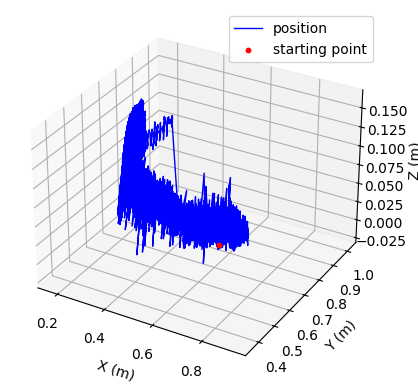

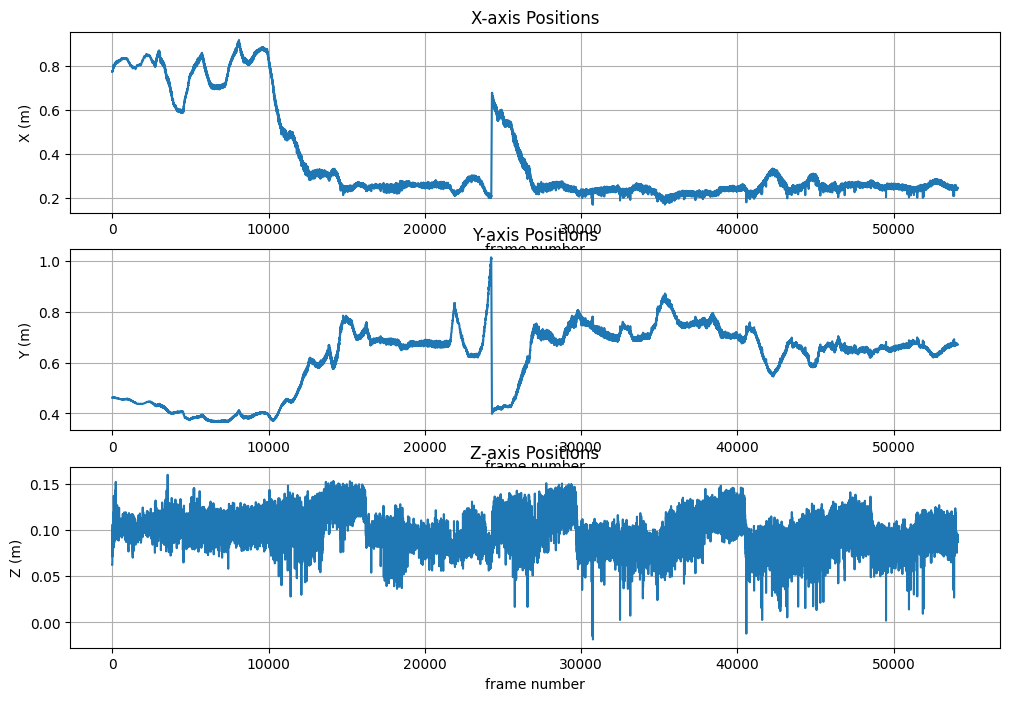

In [110]:
def visualize_xyz(x, y, z, t, time=False):         
    z_axis = t if time else z        

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x, y, z_axis, color='blue', label='position', linewidth=1)
    ax.scatter(x[0], y[0], z_axis[0], color='red', s=10, label='starting point')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    zlabel = 'Frame number' if time else 'Z (m)'
    ax.set_zlabel(zlabel)
    ax.legend()
    
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, x)
    plt.title("X-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("X (m)")
    plt.grid()
    
    plt.subplot(3, 1, 2)
    plt.plot(t, y)
    plt.title("Y-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("Y (m)")
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.plot(t, z)
    plt.title("Z-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("Z (m)")
    plt.grid()
    plt.show()

    plt.show()
visualize_xyz(pose_datas.x, pose_datas.y, pose_datas.z, pose_datas.t, False)

In [ ]:

def vizualize_3D(self):
    # Define the initial rectangle (relative to the origin)
    initial_rectangle = np.array([
        [-0.5, -0.5, 0],  # Bottom-left
        [17.5, -0.5, 0],   # Bottom-right
        [17.5, 6.5, 0],    # Top-right
        [-0.5, 6.5, 0],   # Top-left
        [-0.5, -0.5, 0],  # Close rectangle
    ])
    coord = []
    rot = []
    for i in range(1, self.nbFrames):
        if i in self.edmo_poses:
            coord.append(self.edmo_poses[i])
            rot.append(self.edmo_rots[i])

    def rotate_rectangle(rect, angles):
        """Apply 3D rotation to the rectangle vertices."""
        rx, ry, rz = angles
        
        # Rotation matrices
        rot_x = np.array([
            [1, 0, 0],
            [0, np.cos(rx), -np.sin(rx)],
            [0, np.sin(rx), np.cos(rx)],
        ])
        
        rot_y = np.array([
            [np.cos(ry), 0, np.sin(ry)],
            [0, 1, 0],
            [-np.sin(ry), 0, np.cos(ry)],
        ])
        
        rot_z = np.array([
            [np.cos(rz), -np.sin(rz), 0],
            [np.sin(rz), np.cos(rz), 0],
            [0, 0, 1],
        ])
        
        # Combined rotation
        rotation_matrix = rot_z @ rot_y @ rot_x
        return rect @ rotation_matrix.T

    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Update function for animation
    def update(frame):
        ax.clear()
        ax.set_xlim(-50, 50)
        ax.set_ylim(-50, 50)
        ax.set_zlim(0, 10)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Z-axis")
        
        # Get the center and rotation for the current frame
        center = coord[frame]
        rotation = rot[frame]
        
        # Rotate and translate the rectangle
        rect = rotate_rectangle(initial_rectangle, rotation) + center
        
        # Plot the rectangle
        ax.plot(rect[:, 0], rect[:, 1], rect[:, 2], 'b-', linewidth=2)
        ax.scatter(rect[:, 0], rect[:, 1], rect[:, 2], c='r')  # Vertices

    # Animate the rectangle's motion
    ani = FuncAnimation(fig, update, frames=len(coord), interval=100)

    # Show the plot
    plt.show()

In [ ]:
def double_3D_plot(plot_data):
    off1 = plot_data['Offset_motor_1']
    off2 = plot_data['Offset_motor_2']
    amp1 = plot_data['Amp_motor_1']
    amp2 = plot_data['Amp_motor_2']
    phb_diff = plot_data['Phase_difference']
    speeds = plot_data['Speed']
    
    fig = plt.figure(figsize=(12, 7))  # Adjust the figure size for better spacing

    # Left subplot
    ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 columns, 1st plot
    for i in range(len(off1)):
        ax1.scatter(off1[i], off2[i], phb_diff[i], s=speeds[i]*3000, c=amp1[i], marker='o', cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Offset motor 1')
    ax1.set_ylabel('Offset motor 2')
    ax1.set_zlabel('Phase difference')
    ax1.set_title('Graph 1')
    cbar1 = plt.colorbar(ax1.collections[0], ax=ax1, pad=0.1)
    cbar1.set_label('Speed')

    # Right subplot
    ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 columns, 2nd plot
    for i in range(len(off1)):
        ax2.scatter(off1[i], off2[i], phb_diff[i], s=speeds[i]*3000, c=amp2[i], marker='o', cmap='viridis', alpha=0.8)
    ax2.set_xlabel('Offset motor 1')
    ax2.set_ylabel('Offset motor 2')
    ax2.set_zlabel('Phase difference')
    ax2.set_title('Graph 2')
    cbar2 = plt.colorbar(ax2.collections[0], ax=ax2, pad=0.1)
    cbar2.set_label('Speed')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [ ]:
def plot_2D_poses(all_positions:dict[int, list], axes=None, title=None):
    show = True if axes is None else False
    if show:
        # 2d
        # fig, axes = plt.subplots(1, 1, figsize=(12, 10))  

        # 3d
        fig = plt.figure()
        axes = fig.add_subplot(111, projection='3d')

    x = [pos[0] for frame, pos in all_positions.items()]
    y = [pos[1] for frame, pos in all_positions.items()]
    z = [frame for frame, pos in all_positions.items()]    

    axes.plot(x, y, z, marker='o', linestyle='-', color='b', label='Trajectory')
    # axes.plot(x, y, marker='o', linestyle='-', color='b', label='Trajectory')
    if title is not None:
        axes.set_title(title, fontsize=5)
    axes.set_xlim(0, 1.7)
    axes.set_ylim(0, 1.1) 
    axes.grid(True)

    # Show the plot and legend
    if show:
        axes.set_xlabel("X Position", fontsize=12)
        axes.set_ylabel("Y Position", fontsize=12)
        axes.legend(fontsize=12) 
        plt.tight_layout()
        plt.show()
        
# fig, axes = plt.subplots(18, 10, figsize=(18, 12)) # plot all movements for one set of experiment (180)
# axes = axes.flatten()

# plot_2D_poses(exp_edmo_poses[experiment_nb], axes=axes[i], title=f'experiments nb {exp_start+i}')

# plt.tight_layout()
# plt.show()

# <ins> IMU Data</ins>


folder: 0-179
14708
0:00:00.486456
40
0.4 0.5
0.4 0.5
0.4 0.5
Max amplitude frequency: 4.92521076964917
Max amplitude frequency: 4.876257818874081
Max amplitude frequency: 4.876257818874081


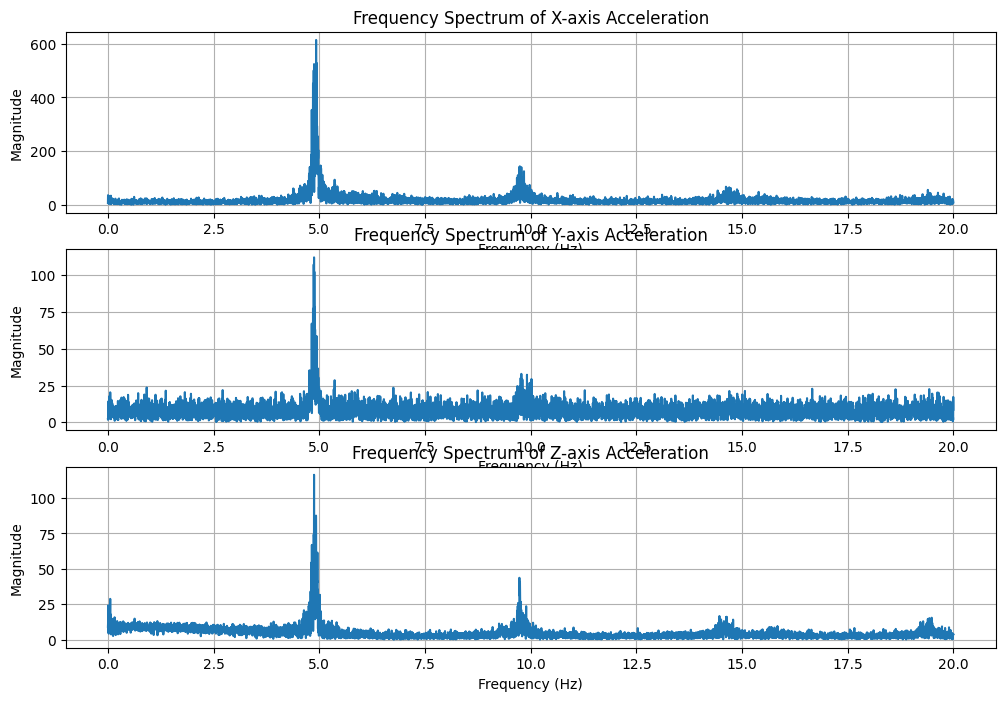

[ 0.0017127  -0.00102058 -0.00228192 ... -0.02798427 -0.01097472
  0.01216242]


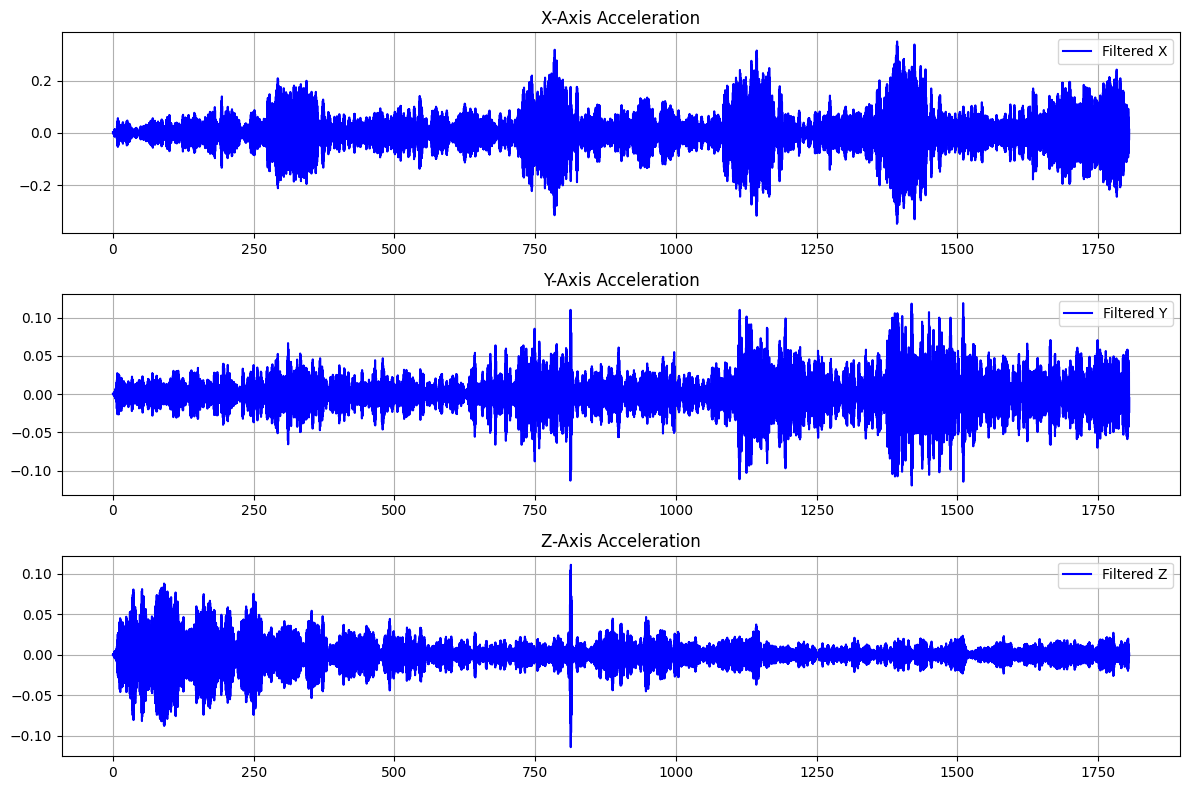

Final Trajectory:
[[    0.             0.             0.        ]
 [    0.             0.             0.        ]
 [    0.             0.             0.        ]
 ...
 [-3506.90144698  -378.54744519 -1492.85715271]
 [-3506.95476244  -378.5781181  -1492.97879233]
 [-3507.02424735  -378.61737217 -1493.13546628]]


In [117]:
def load_IMU_data(file_path):
    data_dict = defaultdict(dict)

    # Regular expression to match the structure of each entry
    entry_pattern = re.compile(
        r"(?P<timestamp>\d+:\d+:\d+\.\d+)\s+"
        r"{Acceleration:\s+{Time:\s*(?P<acc_time>\d+),\s+Status:\s*(?P<acc_status>\d+),\s+Value:\s*\((?P<acc_values>[^)]+)\)},\s*"
        r"Gyroscope:\s+{Time:\s*(?P<gyro_time>\d+),\s+Status:\s*(?P<gyro_status>\d+),\s+Value:\s*\((?P<gyro_values>[^)]+)\)},\s*"
        r"Magnetic:\s+{Time:\s*(?P<mag_time>\d+),\s+Status:\s*(?P<mag_status>\d+),\s+Value:\s*\((?P<mag_values>[^)]+)\)},\s*"
        r"Gravity:\s+{Time:\s*(?P<grav_time>\d+),\s+Status:\s*(?P<grav_status>\d+),\s+Value:\s*\((?P<grav_values>[^)]+)\)},\s*"
        r"Rotation:\s+{Time:\s*(?P<rot_time>\d+),\s+Status:\s*(?P<rot_status>\d+),\s+Value:\s*\((?P<rot_values>[^)]+)\)}"
    )

    # Read the file line by line
    with open(file_path, 'r') as file:
        for line in file:
            match = entry_pattern.search(line)
            if match:
                timestamp = match.group("timestamp")
                # Organize sensor data into a nested dictionary
                data_dict[timestamp] = {
                    "Acceleration": {
                        "Time": int(match.group("acc_time")),
                        "Status": int(match.group("acc_status")),
                        "Value": tuple(map(float, match.group("acc_values").split(",")))
                    },
                    "Gyroscope": {
                        "Time": int(match.group("gyro_time")),
                        "Status": int(match.group("gyro_status")),
                        "Value": tuple(map(float, match.group("gyro_values").split(",")))
                    },
                    "Magnetic": {
                        "Time": int(match.group("mag_time")),
                        "Status": int(match.group("mag_status")),
                        "Value": tuple(map(float, match.group("mag_values").split(",")))
                    },
                    "Gravity": {
                        "Time": int(match.group("grav_time")),
                        "Status": int(match.group("grav_status")),
                        "Value": tuple(map(float, match.group("grav_values").split(",")))
                    },
                    "Rotation": {
                        "Time": int(match.group("rot_time")),
                        "Status": int(match.group("rot_status")),
                        "Value": tuple(map(float, match.group("rot_values").split(",")))
                    }
                }
    return data_dict

from scipy import integrate

from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

def low_pass_filter(data, low_cutoff, high_cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter to the given data.

    Parameters:
        data (array-like): The input data to filter.
        cutoff (float): The cutoff frequency of the filter (Hz).
        fs (float): The sampling frequency (Hz).
        order (int): The order of the filter.

    Returns:
        filtered_data (ndarray): The filtered data.
    """
    low = low_cutoff / (0.5 * fs)
    high = high_cutoff /(0.5 * fs)
    print(low, high)
    b, a = butter(order, [low, high], btype='band', analog=False)
    # b, a = butter(order, low, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def compute_position(data_dict, cutoffs):
    # Initialize lists for time, acceleration, velocity, and position
    timestamps = []
    accelerations = []

    # Extract timestamps and acceleration values
    for timestamp, sensors in data_dict.items():
        acc = sensors["Acceleration"]["Value"]
        if len(timestamps) != 0 and timestamp < timestamps[-1]:
            print(f"Skipped timestamps {len(timestamps)}")
            timestamps = []
            accelerations = []
        timestamps.append(timestamp)
        accelerations.append(acc)

    # Convert timestamps to seconds since start
    start_time = timestamps[0]
    print(start_time)
    time_in_seconds = [
        sum(float(x) * t for x, t in zip(ts.split(":"), [3600, 60, 1]))
        - sum(float(x) * t for x, t in zip(start_time.split(":"), [3600, 60, 1]))
        for ts in timestamps
    ]

    # Convert acceleration list to numpy array
    accelerations = np.array(accelerations)
    time_in_seconds = np.array(time_in_seconds)

    # Apply low-pass filter
    # sampling_frequency = 1 / np.mean(np.diff(time_in_seconds))  # Hz
    sampling_frequency = 40
    print(sampling_frequency)
    filtered_accs = []
    for i, cutoff in enumerate(cutoffs):
        filtered_accs.append(low_pass_filter(accelerations[:, i], cutoff[0], cutoff[1], sampling_frequency))
    filtered_accelerations = np.column_stack(filtered_accs)

    # Integrate acceleration to find velocity (v = ∫a dt)
    velocities = integrate.cumulative_trapezoid(filtered_accelerations, time_in_seconds, axis=0, initial=0)

    # Integrate velocity to find position (s = ∫v dt)
    positions = integrate.cumulative_trapezoid(velocities, time_in_seconds, axis=0, initial=0)

    plot_fft = True
    if plot_fft:
        n = len(accelerations[:,0])  # Number of samples

        freqs = np.fft.rfftfreq(n, d=1/sampling_frequency)  # Frequency bins
        fft_magnitude_x = np.abs(np.fft.rfft(accelerations[:,0]))  
        fft_magnitude_y = np.abs(np.fft.rfft(accelerations[:,1]))  
        fft_magnitude_z = np.abs(np.fft.rfft(accelerations[:,2]))  
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_x)]}')
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_y)]}')
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_z)]}')

        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(freqs, fft_magnitude_x)
        plt.title("Frequency Spectrum of X-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        
        plt.subplot(3, 1, 2)
        plt.plot(freqs, fft_magnitude_y)
        plt.title("Frequency Spectrum of Y-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        
        plt.subplot(3, 1, 3)
        plt.plot(freqs, fft_magnitude_z)
        plt.title("Frequency Spectrum of Z-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        plt.show()

    # Plotting the filtered acceleration data
    plot_filtered = True
    if plot_filtered:
        plt.figure(figsize=(12, 8))
        print(filtered_accs[0])
        # X-axis
        plt.subplot(3, 1, 1)
        # plt.plot(time_in_seconds, acc_x, label="Original X", color="red", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[0], label="Filtered X", color="blue")
        plt.title("X-Axis Acceleration")
        plt.legend()
        plt.grid()

        # Y-axis
        plt.subplot(3, 1, 2)
        # plt.plot(time_in_seconds, acc_y, label="Original Y", color="green", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[1], label="Filtered Y", color="blue")
        plt.title("Y-Axis Acceleration")
        plt.legend()
        plt.grid()

        # Z-axis
        plt.subplot(3, 1, 3)
        # plt.plot(time_in_seconds, acc_z, label="Original Z", color="purple", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[2], label="Filtered Z", color="blue")
        plt.title("Z-Axis Acceleration")
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
        interactive_plot(filtered_accs[0],filtered_accs[1],filtered_accs[2],time_in_seconds,False)
    return positions




dir = './cleanData/Snake'
# dir = './exploreData/Snake'
for folder in os.listdir(dir):
    if folder == '1080-1259':
        break
    if os.path.splitext(folder)[1] != '':
        continue
    print(f'folder: {folder}')
    filepath = f'{dir}/{folder}'
    IMU_data = None
    for file in os.listdir(filepath):
        if file == "IMU.log":
            IMU_data = load_IMU_data(f'{filepath}/{file}')
            break
    print(len(IMU_data))
    positions = compute_position(IMU_data, ((8,10),)*3) 
    # Output positions
    """for i, pos in enumerate(positions):
        print(f"Position at t={i}: {pos}")
    
    prev_time = None
    for timestamp in IMU_data.keys():
        if prev_time is None:
            prev_time = timestamp
            continue
        print(IMU_data[timestamp])
        print(IMU_data[timestamp]['Gravity'])
        break
 """       
 
    # Initialize variables
    position = np.array([0.0, 0.0, 0.0])  # Starting position (0, 0, 0)
    velocity = np.array([0.0, 0.0, 0.0])  # Starting velocity (0, 0, 0)
    previous_time = 0.0
    trajectory = []  # List to store the positions over time

    # Iterate through the data (assuming 'data_dict' contains the IMU data)
    for timestamp, sensor_data in IMU_data.items():
        # Extract acceleration data and time from the dictionary
        acc = np.array(sensor_data["Acceleration"]["Value"])
        current_time = float(sum(float(x) * t for x, t in zip(timestamp.split(":"), [3600, 60, 1])))
        
        # Time step between current and previous data point
        delta_time = current_time - previous_time
        
        if delta_time <= 0:
            continue  # Skip if the time step is non-positive (corrupted data)
        
        # Update velocity using numerical integration (Euler's method)
        velocity += acc * delta_time  # v(t) = v(t-1) + a * dt
        
        # Update position using numerical integration (Euler's method)
        position += velocity * delta_time  # p(t) = p(t-1) + v * dt
        
        # Store the current position in the trajectory list
        trajectory.append(position.copy())
        
        # Update the previous time for the next iteration
        previous_time = current_time

    # Convert trajectory to numpy array for easier manipulation
    trajectory = np.array(trajectory)

    # Print final trajectory (positions over time)
    print("Final Trajectory:")
    print(trajectory)
                    
